<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scrape-FT-reports-of-1000-fastest-growing-company-in-Europe" data-toc-modified-id="Scrape-FT-reports-of-1000-fastest-growing-company-in-Europe-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scrape FT reports of 1000 fastest growing company in Europe</a></span></li><li><span><a href="#Grab-the-table-from-the-Report-Websites" data-toc-modified-id="Grab-the-table-from-the-Report-Websites-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grab the table from the Report Websites</a></span></li><li><span><a href="#Country-Overview" data-toc-modified-id="Country-Overview-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Country Overview</a></span></li><li><span><a href="#Swedish-Fast-Growing-Companies" data-toc-modified-id="Swedish-Fast-Growing-Companies-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Swedish Fast Growing Companies</a></span><ul class="toc-item"><li><span><a href="#Swedish-Unicorns" data-toc-modified-id="Swedish-Unicorns-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Swedish Unicorns</a></span></li><li><span><a href="#Swedish-fast-growth-companies-total" data-toc-modified-id="Swedish-fast-growth-companies-total-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Swedish fast growth companies total</a></span></li></ul></li></ul></div>

## Scrape FT reports of 1000 fastest growing company in Europe
Interesting article with data is worth a little deeper digging. The deal here is to grab that data and analyze!


## Grab the table from the Report Websites
Grabbing all the data from past reports from 2017 to 2020.

*    2020 : https://www.ft.com/content/691390ca-53d9-11ea-90ad-25e377c0ee1f
*    2019 : https://www.ft.com/content/238174d2-3139-11e9-8744-e7016697f225
*    2018 : https://www.ft.com/content/cf0c5fce-3112-11e8-b5bf-23cb17fd1498
*    2017 : https://ig.ft.com/ft-1000/


In [118]:
%load_ext autoreload
%autoreload 2
import os, sys
import time
import pickle
import requests
import pandas as pd
import numpy as np
from requests_html import HTML 
from time import sleep
from typing import List
from matplotlib import pyplot as plt
%matplotlib inline




def url_to_file(url: str='https://www.ft.com/content/691390ca-53d9-11ea-90ad-25e377c0ee1f', 
                fname: str=None):
    r=requests.get(url)
    if r.status_code==200:
        if fname:
            with open(fname, 'w') as f:
                f.write(r.text)
                print(f'html texts saved to {fname}')
        return r.text
    return ""

def grab_table(html_text:str, year:str, fname: str=None):
    r_html=HTML(html=html_text)
    o_table=r_html.find("table")
    # grab header columns
    header_col=[x.text for x in o_table[0].find('th')]
    # grab table and convert to dataframe
    rows = []
    ilen = len(header_col)
    for  row in o_table[0].find('tbody')[0].find('tr'):
        cells=row.find('td')
        dict_row = {header_col[i]:cells[i].text for i in range(ilen)}
        rows.append(dict_row)
    df=pd.DataFrame(rows)
    df['YearPub']=year
    if fname:
        df.to_pickle(f'df_{fname}.pickle')
    return df


def url_to_table(url:str, year:str, fname: str=None):
    html_text = url_to_file(url=url, fname=f'ft1000_{fname}.html')
    df = grab_table(html_text, year=year, fname=fname)
    return df




def get_raw_tables(dict_url:dict):
    for yearnbr in sorted(dict_url.keys()):
        df = url_to_table(dict_url[yearnbr], year=yearnbr, fname=yearnbr)

def kw_over_x(kw, x):
    if kw.lower() in x.lower():
        if kw=='employees':
            kw='employees_2yr_ago'
        return kw
    else: 
        return x

def clean_rev(x, year):
    if 'Revenue' in x and str(year-2) in x:
        return 'revenue_2yr_ago'
    else: 
        return x
    
def clean_concat_tables(dict_url):    
    dfs = []
    for year in sorted(dict_url.keys()):
        df = pd.read_pickle(f'df_{year}.pickle')
        df.rename(columns={'':'Rank', 'FT Category':'Sector', 
                           'Founding Year':'founded', 'Location':'country', 'Name':'company'}, inplace=True)
        df.columns = [kw_over_x('employees', x) for x in df.columns]
        df.columns = [kw_over_x('CAGR', x) for x in df.columns]
        df.columns = [clean_rev(x, year) for x in df.columns]
        df.columns = [x.lower() for x in df.columns]
        df = df[['rank','company', 'cagr','sector','employees_2yr_ago', 'revenue_2yr_ago','country', 'founded', 'yearpub']]
        num_cols=['rank', 'cagr','employees_2yr_ago', 'revenue_2yr_ago', 'founded', 'yearpub']
        for col in num_cols:
            if df[col].dtypes=='O':
                df[col] = [str.replace(x, ',', '') for x in df[col]]
                df[col] = [str.replace(x, '%', '') for x in df[col]]
                df[col] = np.where((df[col]=='')|( df[col]=='n/a') , None, df[col])        
                df[col]=df[col].astype('float').round(decimals=1)
        df['country']=[str.replace(x, 'The ', '').lower()for x in df['country']]
        dfs.append(df)
    df=pd.concat(dfs)
    df.to_pickle(f'df_all.pickle')
    return df

    
def process_data():
    url2020 = 'https://www.ft.com/content/691390ca-53d9-11ea-90ad-25e377c0ee1f'
    url2019 = 'https://www.ft.com/content/238174d2-3139-11e9-8744-e7016697f225'
    url2018 = 'https://www.ft.com/content/cf0c5fce-3112-11e8-b5bf-23cb17fd1498'
    url2017 = 'https://ig.ft.com/ft-1000/'
    dict_url = {2020:url2020, 2019:url2019, 2018:url2018, 2017:url2017}
    # get raw tables
    get_raw_tables(dict_url)
    # clean tables
    return clean_concat_tables(dict_url)
df=process_data()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
!ls

1_Get_Data.ipynb    df_2019.pickle      dfproc_2018.pickle  ft1000_2017.html
df.pickle           df_2020.pickle      dfproc_2019.pickle  ft1000_2018.html
df_2017.pickle      df_all.pickle       dfproc_2020.pickle  ft1000_2019.html
df_2018.pickle      dfproc_2017.pickle  ft1000-2020mar.html ft1000_2020.html


## Country Overview
Sweden is ranked No.8 in "company x year" counts.

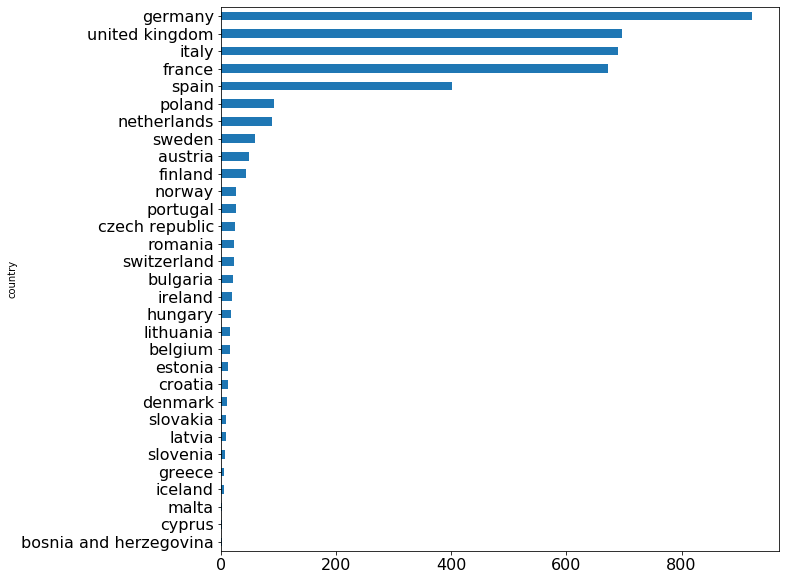

In [250]:
df.groupby('country').size().sort_values().plot.barh(figsize=(10,10), fontsize=16)

## Swedish Fast Growing Companies 
### Swedish Unicorns
Some unicorn companies were listed multiple years by FT as fastest 1000 companies.

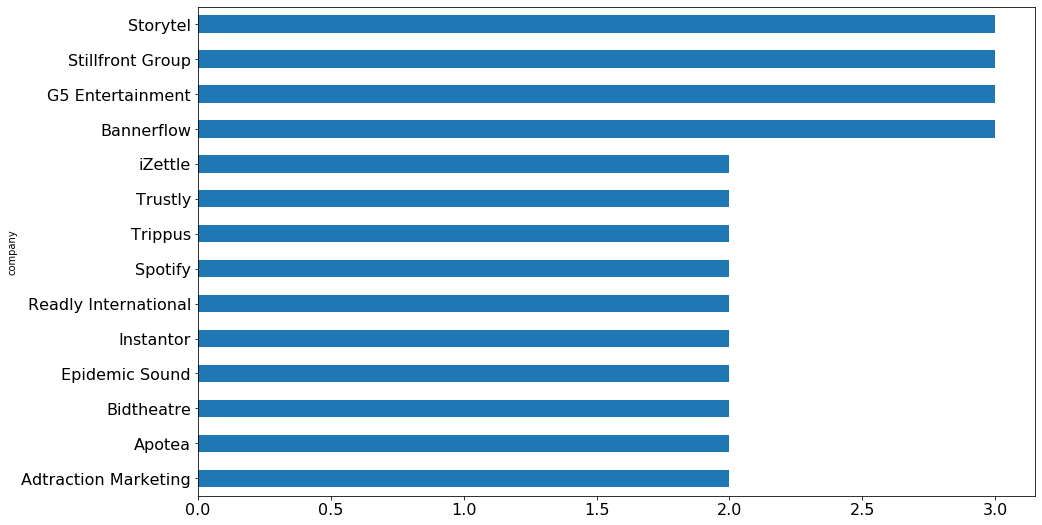

In [245]:
def get_unicorn(country):
    sw = df[df['country']==country]
    sw_agg = sw.groupby('company').size()
    unicorns=sw_agg.loc[sw_agg>1]
    unicorns.sort_values().plot.barh(figsize=(15,9), fontsize=16)
    return sw, sw.set_index('company').loc[unicorns.index].reset_index()

sw, sw_unicorn = get_unicorn('sweden')

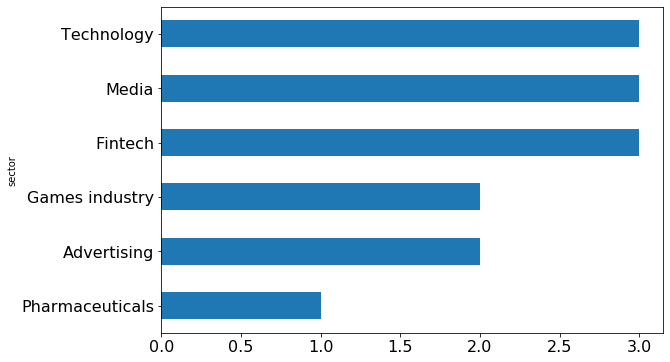

In [246]:
sw_unicorn.groupby('sector')['company'].nunique().sort_values().plot.barh(figsize=(9,6), fontsize=16)

In [247]:
sw_unicorn.groupby(['company', 'sector'], as_index=False).agg({
    'yearpub':['unique', 'min'], 
    'founded':'min',
    'revenue_2yr_ago':['min','mean','max'],
    'cagr':['min','mean','max'],  
    'employees_2yr_ago':['min','mean','max']}).sort_values(by=[('employees_2yr_ago','max'), ('yearpub', 'min')], ascending=False)



company           sector             yearpub       founded  \
                                                       unique   min     min   
8                Spotify            Media        [2017, 2018]  2017  2006.0   
9       Stillfront Group   Games industry  [2018, 2019, 2020]  2018  2010.0   
5       G5 Entertainment   Games industry  [2018, 2019, 2020]  2018  2001.0   
10              Storytel            Media  [2017, 2018, 2019]  2017  2005.0   
13               iZettle          Fintech        [2017, 2018]  2017  2010.0   
1                 Apotea  Pharmaceuticals        [2018, 2019]  2018  2012.0   
4         Epidemic Sound       Technology        [2019, 2020]  2019  2009.0   
12               Trustly          Fintech        [2017, 2018]  2017  2008.0   
6              Instantor          Fintech        [2018, 2019]  2018  2010.0   
2             Bannerflow      Advertising  [2017, 2018, 2019]  2017  2010.0   
7   Readly International            Media        [2019, 2020]  2019  2012.0   
0   Adtraction Marketing      Advertising        [2018, 2019]  2018  2007.0   
11               Trippus       Technology        [2017, 2018]  2017  2000.0   
3             Bidtheatre       Technology        [2019, 2020]  2019  2012.0   

   revenue_2yr_ago                            cagr                     \
               min          mean        max    min        mean    max   
8        1945332.0  2.439418e+06  2933504.0   57.8   61.600000   65.4   
9             17.3  3.390800e+03    10026.0   66.1  110.033333  185.3   
5            118.5  1.830360e+04    54651.0   53.5   57.566667   63.5   
10           122.2  3.688540e+04    78647.0  103.4  111.300000  122.9   
13         36841.0  5.231200e+04    67783.0  102.5  158.950000  215.4   
1            156.6  5.122730e+04   102298.0   73.3   90.600000  107.9   
4             11.8  1.665000e+01       21.5   70.8   78.600000   86.4   
12         20015.0  2.616250e+04    32310.0   81.8   85.150000   88.5   
6              2.8  8.369000e+02     1671.0   52.1   64.350000   76.6   
2              6.5  2.393167e+03     4469.0   61.2   63.533333   66.0   
7             13.2  1.610000e+01       19.0   69.3   85.600000  101.9   
0             29.0  1.022350e+04    20418.0   50.5   54.900000   59.3   
11          4403.0  6.024000e+03     7645.0   45.8   53.700000   61.6   
3              8.4  9.700000e+00       11.0   54.3   73.950000   93.6   

   employees_2yr_ago                       
                 min         mean     max  
8             1610.0  1886.000000  2162.0  
9               96.0   238.666667   491.0  
5              299.0   378.333333   490.0  
10              56.0   176.333333   309.0  
13             256.0   273.000000   290.0  
1              236.0   258.500000   281.0  
4              146.0   212.000000   278.0  
12              71.0   110.500000   150.0  
6               30.0    40.000000    50.0  
2               35.0    42.000000    49.0  
7               31.0    37.500000    44.0  
0               12.0    26.000000    40.0  
11              16.0    18.000000    20.0  
3                7.0     7.000000     7.0

### Swedish fast growth companies total
All the fast growing companies unicorns or not.

In [248]:
sw.groupby(['company', 'sector'], as_index=False).agg({
    'yearpub':['unique', 'min'], 
    'founded':'min',
    'revenue_2yr_ago':['min','mean','max'],
    'cagr':['min','mean','max'],  
    'employees_2yr_ago':['min','mean','max']}).sort_values(by=[('employees_2yr_ago','max'), ('yearpub', 'min')], ascending=False)



company                      sector  \
                                                                 
30                         Spotify                       Media   
31                Stillfront Group              Games industry   
15                G5 Entertainment              Games industry   
10              CLX Communications                  Technology   
32                        Storytel                       Media   
2                           Accedo                  Technology   
41                         iZettle                     Fintech   
4                           Apotea             Pharmaceuticals   
11                  Epidemic Sound                  Technology   
16                        G5 Games              Games industry   
17                  GomSpace Group                  Technology   
39                       Widespace                 Advertising   
37                   Trustly Group                     Fintech   
36                         Trustly                     Fintech   
33                         Telavox                    Telecoms   
14                          Fyndiq                   Ecommerce   
21         Matsmart in Scandinavia                   Ecommerce   
13               Fram Skandinavien                  Technology   
23                 Northmill Group                     Fintech   
19          KKRUT Sociala Tjänster                      Health   
18                       Instantor                     Fintech   
7                       Bannerflow                 Advertising   
27            Readly International                       Media   
12                       FEO Media              Games industry   
3             Adtraction Marketing                 Advertising   
40                Wiraya Solutions                  Technology   
38             Umeå Release Finans          Financial Services   
26               Qred Företagslån*                     Fintech   
28        Slagkryssaren Aktiebolag            Support Services   
25                        Parkster                  Technology   
20                     Limes Audio                    Telecoms   
1   A Day's March Shirts & Staples                      Retail   
34                         Trippus                  Technology   
5                   Arc E-Commerce                   Ecommerce   
9                          Bygglet                  Technology   
24                          Nuiteq                  Technology   
22                          Mavera                   Insurance   
6         Badtunna Skärgårdstunnan  Personal & Household Goods   
0                          84codes                  Technology   
35                    Tripx Travel            Travel & Leisure   
8                       Bidtheatre                  Technology   
29             Solar Supply Sweden                      Energy   

               yearpub       founded revenue_2yr_ago                           \
                unique   min     min             min          mean        max   
30        [2017, 2018]  2017  2006.0       1945332.0  2.439418e+06  2933504.0   
31  [2018, 2019, 2020]  2018  2010.0            17.3  3.390800e+03    10026.0   
15  [2018, 2019, 2020]  2018  2001.0           118.5  1.830360e+04    54651.0   
10              [2019]  2019  2008.0           319.3  3.193000e+02      319.3   
32  [2017, 2018, 2019]  2017  2005.0           122.2  3.688540e+04    78647.0   
2               [2017]  2017  2004.0         34485.0  3.448500e+04    34485.0   
41        [2017, 2018]  2017  2010.0         36841.0  5.231200e+04    67783.0   
4         [2018, 2019]  2018  2012.0           156.6  5.122730e+04   102298.0   
11        [2019, 2020]  2019  2009.0            11.8  1.665000e+01       21.5   
16              [2017]  2017  2001.0         41046.0  4.104600e+04    41046.0   
17              [2020]  2020  2015.0            15.0  1.500000e+01       15.0   
39              [2017]  2017  2007.0         37828.0  3.782800e+04   

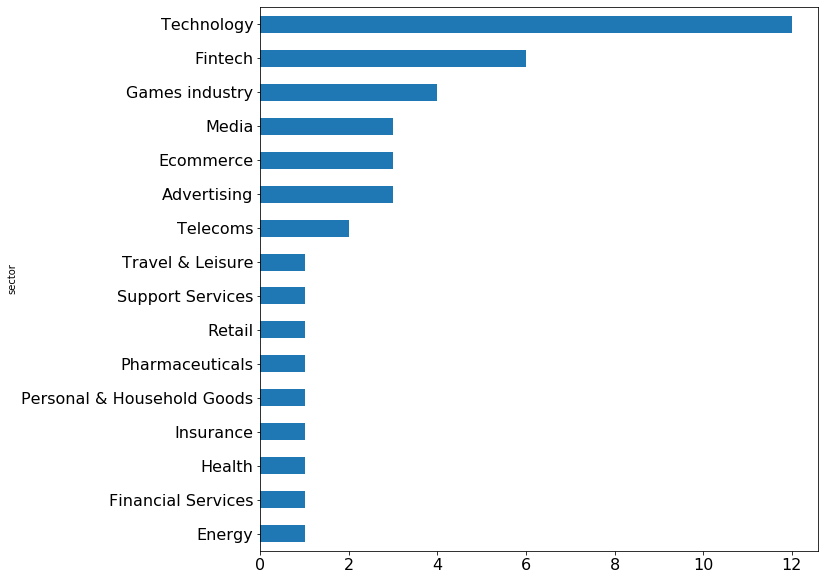

In [252]:
sw.groupby('sector')['company'].nunique().sort_values().plot.barh(figsize=(10,10), fontsize=16)

In [253]:
pwd

'/Users/shuyili/Documents/alcoholfreebear/ft1000-webscrap'